In [1]:
%cd ..


/Users/eliaweiss/ai/segmentation/MobileSAM


In [22]:
import numpy as np
from TableDetect import TableDetect
from MobileSamBoxes import MobileSamBoxes
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
import torch

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

  
def plot_results(model, pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=3))
        cl = p.argmax().item()
        score = p[cl]
        text = f'{model.config.id2label[cl]}: {score:0.2f}'
        
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
        
def show_anns(anns):
    if len(anns) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((anns.shape[1], anns.shape[2], 4))
    img[:,:,3] = 0
    for ann in range(anns.shape[0]):
        m = anns[ann].bool()
        m=m.cpu().numpy()
        color_mask = np.concatenate([np.random.random(3), [1]])
        img[m] = color_mask
    ax.imshow(img)


def plot_annotations(anns):
    plt.figure(figsize=(10,10))
    background=np.ones_like(sam.image)*255
    plt.imshow(background)
    show_anns(anns)
    plt.axis('off')
    plt.show() 
    # plt.savefig("{}".format("./out/result.jpg"), bbox_inches='tight', pad_inches = 0.0)         


# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

In [3]:
# file_path = "./app/assets/picture1.jpg"
file_path = "/Users/eliaweiss/Documents/doc2txt/sihach/attachments/img/20231025012642_001.jpg"
# file_path = "/Users/eliaweiss/Documents/doc2txt/invoices 2/expense (6).jpeg"

img = Image.open(file_path)
tblDec = TableDetect()
probas, boxes = tblDec.detectTables(img)



Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


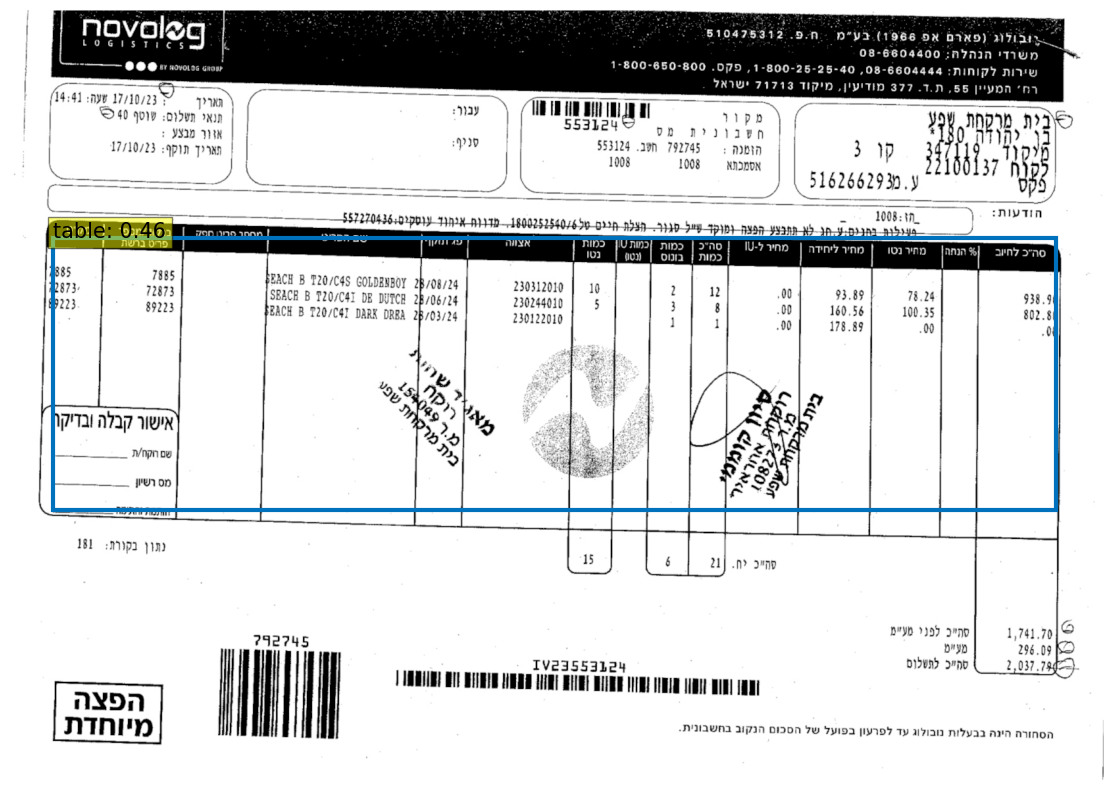

In [4]:
plot_results(tblDec.model, img, probas, boxes)


# Crop table with sam

In [5]:
sam = MobileSamBoxes(img)
anns = sam.process(boxes)

checkpoint_load_scucess
shape (1201, 1706, 3)
------ total time: (s): 6.16


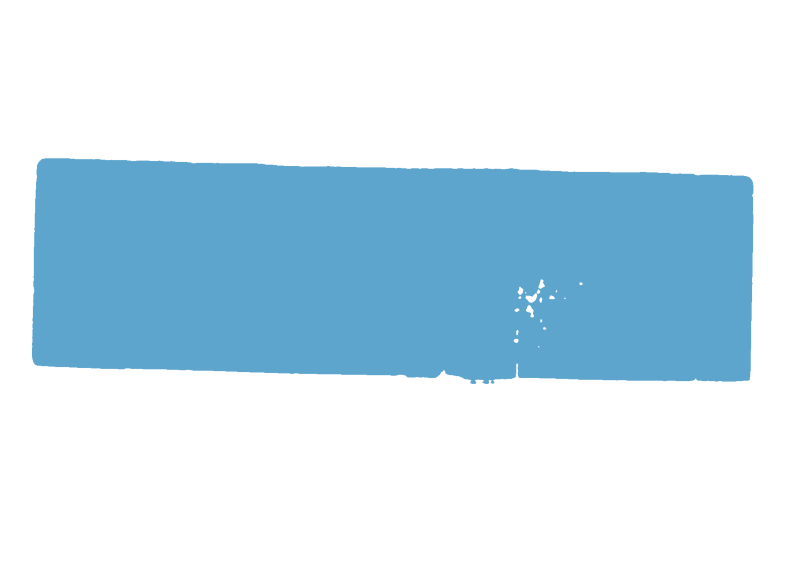

In [6]:
plot_annotations(anns)



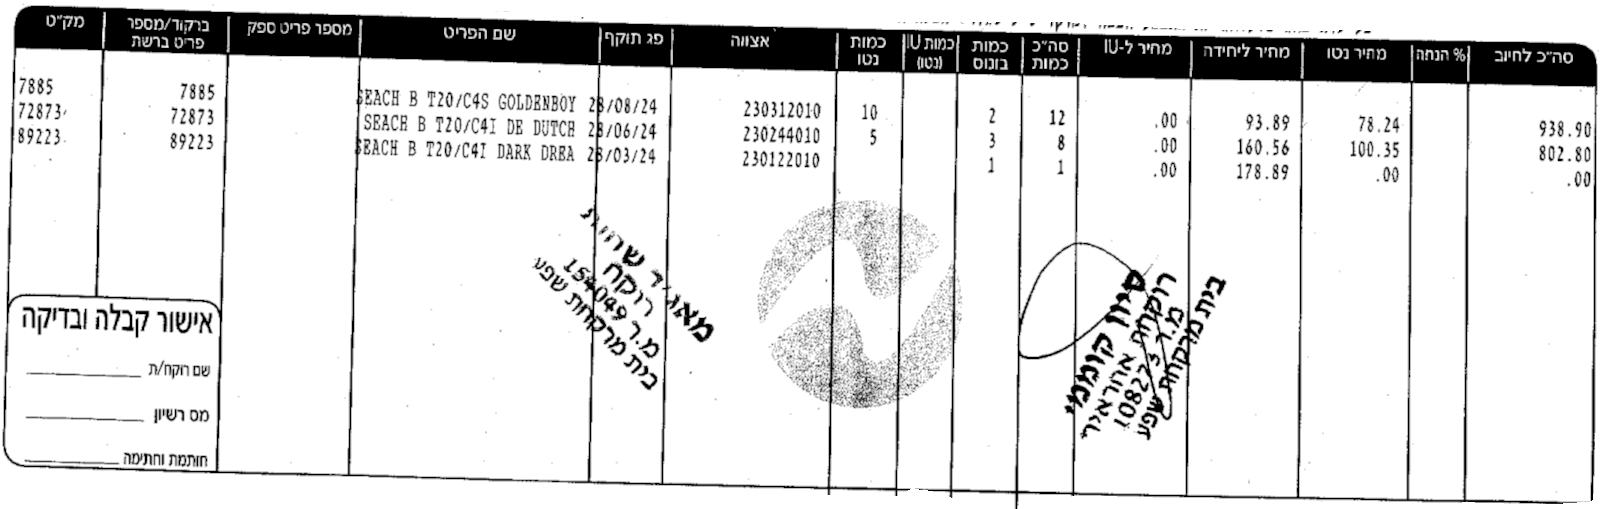

In [11]:
from PIL import Image
import cv2

def create_mask_patch(image, mask):
  """
  Creates a patch from the image containing only the mask region.

  Args:
      image: A PIL image object.
      mask: A NumPy array representing the mask (1 for mask pixels).

  Returns:
      A PIL image object containing the patch from the original image 
      with only the mask region and white background for non-mask pixels.
  """
  mask=mask.cpu().numpy()
  mask = cv2.dilate(mask, np.ones((13, 13), np.uint8), iterations=1)  
  # Find non-zero elements (mask pixels) in the mask
  mask_coords = np.where(mask != 0)

  # Get minimum and maximum coordinates from the mask pixels
  min_y, min_x = mask_coords[0].min(), mask_coords[1].min()
  max_y, max_x = mask_coords[0].max() + 1, mask_coords[1].max() + 1  # Add 1 for inclusive range

  # Create the bounding box rectangle
  bounding_box = (min_x, min_y, max_x, max_y)


  mask = mask==1
  imgArr = np.array(image)
  imgArr[~mask] = (255,255,255)
  image = Image.fromarray(imgArr)
  # color_mask = np.concatenate([np.random.random(3), [1]])
  # img[m] = color_mask
  # Crop the image using the bounding box
  patch_image = image.crop(bounding_box)
  return patch_image

# Example usage
mask = anns[0]

tbl_patch = create_mask_patch(img, mask)
# patch.show()  # Display the created patch
tbl_patch


# Table structure recognition

In [12]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(tbl_patch, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [18]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from transformers import TableTransformerForObjectDetection

# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)

In [16]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [20]:
pixel_values = structure_transform(tbl_patch).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 318, 1000])


In [21]:
# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

In [23]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, tbl_patch.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9987970590591431, 'bbox': [103.1017074584961, 16.053302764892578, 228.24636840820312, 464.9497375488281]}, {'label': 'table column', 'score': 0.9253242015838623, 'bbox': [1373.23583984375, 15.599677085876465, 1463.499755859375, 464.48553466796875]}, {'label': 'table column', 'score': 0.9981472492218018, 'bbox': [696.2577514648438, 15.935465812683105, 831.5797119140625, 463.71160888671875]}, {'label': 'table column', 'score': 0.9882992506027222, 'bbox': [1082.1842041015625, 15.897588729858398, 1190.475341796875, 464.4013977050781]}, {'label': 'table projected row header', 'score': 0.875931441783905, 'bbox': [15.062918663024902, 265.7318420410156, 1593.1295166015625, 332.60162353515625]}, {'label': 'table column', 'score': 0.8074873089790344, 'bbox': [970.2816162109375, 15.413093566894531, 1029.3585205078125, 466.1374816894531]}, {'label': 'table projected row header', 'score': 0.8308645486831665, 'bbox': [14.95761489868164, 330.92620849609375, 1593.

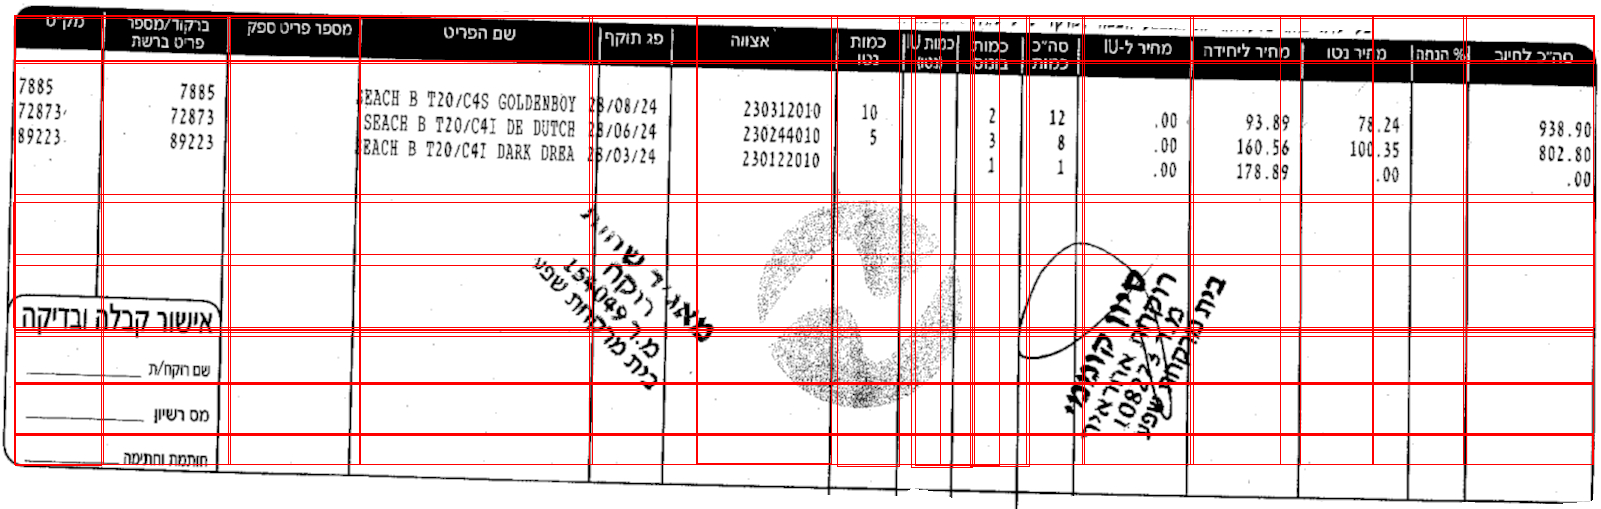

In [25]:
from PIL import ImageDraw

cropped_table_visualized = tbl_patch.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

In [38]:
def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError(f"Class should be one of the available classes {structure_model.config.id2label}")

    plt.figure(figsize=(16,10))
    plt.imshow(tbl_patch)
    ax = plt.gca()

    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
          # text = f'{cell["label"]}: {score:0.2f}'
          # ax.text(xmin, ymin, text, fontsize=15,
          #         bbox=dict(facecolor='yellow', alpha=0.5))
          plt.axis('off')

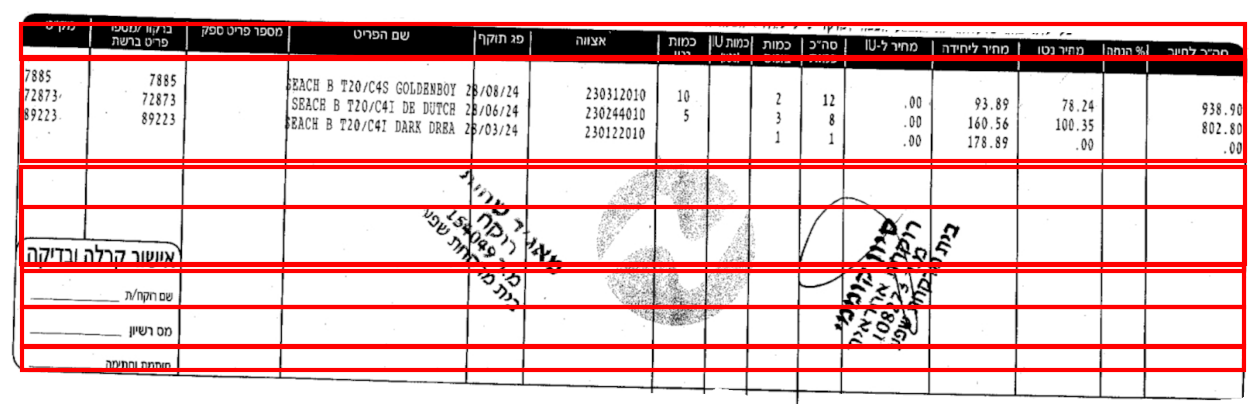

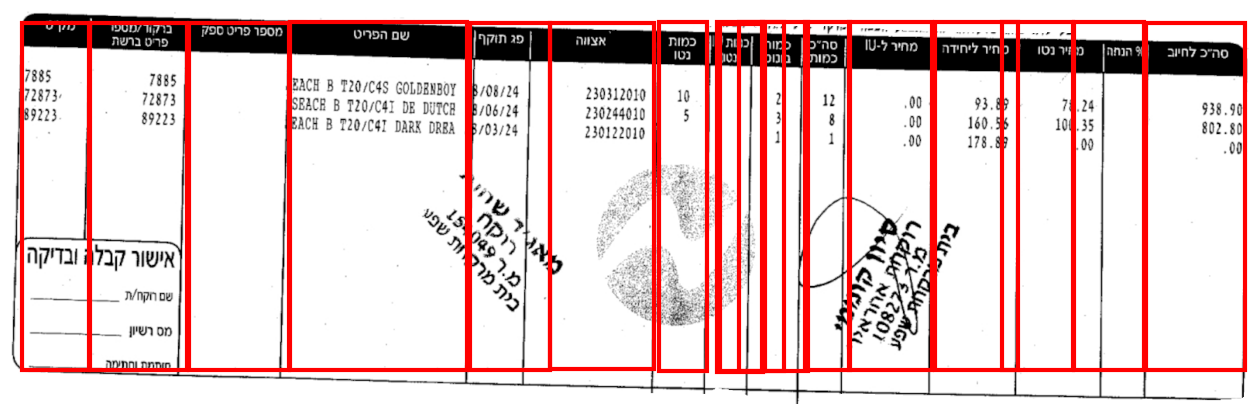

In [39]:
plot_results(cells, class_to_visualize="table row")
plot_results(cells, class_to_visualize="table column")
# plot_results(cells, class_to_visualize="table column header")
# plot_results(cells, class_to_visualize="table projected row header")
# plot_results(cells, class_to_visualize="table spanning cell")